In [73]:
# Load required libraries

# Load required libraries

import pandas as pd
import numpy as np
import sklearn as sk
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

import re
import random

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn import Dropout
from torch.nn import Linear
from tqdm import tqdm
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from transformers import DistilBertConfig
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



from sklearn.metrics.pairwise import cosine_similarity

In [74]:
import pandas as pd
import pandas as pd
from sklearn.utils import resample
df_1 = pd.read_csv('/kaggle/input/equal-sample/equal_sample_english_songs_50000.csv')

In [75]:

# Sample 10000 random records from the dataset
df = resample(df_1, n_samples=10000, random_state=42, replace=False)

# Get the counts of each tag/category
tag_counts = df['tag'].value_counts()

print(tag_counts)

tag
country    2043
rap        2016
rb         1998
pop        1993
rock       1950
Name: count, dtype: int64


In [76]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, AdamW
from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import torch

In [77]:
# Display the dimensions of the DataFrame
print(df.shape)

# Calculate the count of each value in the "Trainings-Labels" column
label_counts = df['tag'].value_counts()

# Print the label counts
print(label_counts)

(10000, 11)
tag
country    2043
rap        2016
rb         1998
pop        1993
rock       1950
Name: count, dtype: int64


In [78]:
label_mapping = {'pop': 0, 'rap': 1, 'rock': 2, 'rb': 3, "country": 4}

lyrics_list = df['lyrics'].tolist()
tag_list = df['tag'].tolist()

numeric_labels = torch.tensor([label_mapping[label] for label in tag_list])
numeric_labels

tensor([3, 4, 4,  ..., 0, 0, 4])

In [79]:
label_counts = pd.Series(numeric_labels).value_counts()
print(label_counts)

4    2043
1    2016
3    1998
0    1993
2    1950
Name: count, dtype: int64


In [80]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
class SongsDataset(Dataset):
    def __init__(self, songs, labels, tokenizer):
        self.songs = songs
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        song = str(self.songs[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            song,
            truncation=True,
            padding='max_length',
            max_length=300,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [82]:
k = 2# number of folds

skf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

# Lists for saving the training and test data
train_lyrics_list = []
test_lyrics_list = []
train_labels_list = []
test_labels_list = []

# K-Fold cross-validation for splitting the data
for train_index, test_index in skf.split(lyrics_list, numeric_labels):
    train_lyrics = [lyrics_list[i] for i in train_index]
    test_lyrics = [lyrics_list[i] for i in test_index]
    train_labels = [numeric_labels[i].item() for i in train_index]
    test_labels = [numeric_labels[i].item() for i in test_index]

    train_lyrics_list.append(train_lyrics)
    test_lyrics_list.append(test_lyrics)
    train_labels_list.append(train_labels)
    test_labels_list.append(test_labels)

In [83]:
# Create training and test records for each fold
train_datasets = []
test_datasets = []

for fold in range(k):
    train_dataset = SongsDataset(train_lyrics_list[fold], train_labels_list[fold], tokenizer)
    test_dataset = SongsDataset(test_lyrics_list[fold], test_labels_list[fold], tokenizer)

    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)

# Create training and test data loaders for each fold
train_dataloaders = []
test_dataloaders = []

for fold in range(k):
    train_dataloader = DataLoader(train_datasets[fold], batch_size=16, shuffle=True)
    test_dataloader = DataLoader(test_datasets[fold], batch_size=16, shuffle=False)

    train_dataloaders.append(train_dataloader)
    test_dataloaders.append(test_dataloader)

In [84]:
# Checking the number of records in the training and test datasets
for fold in range(k):
    print(f"Fold {fold+1}")
    train_dataset = train_datasets[fold]
    test_dataset = test_datasets[fold]

    print(f"Number of training data: {len(train_dataset)}")
    print(f"Number of testing data: {len(test_dataset)}")

# Verify the number of batches in the training and test data loaders.
for fold in range(k):
    print(f"Fold {fold+1}")
    train_dataloader = train_dataloaders[fold]
    test_dataloader = test_dataloaders[fold]

    print(f"Number of batches in the training dataloader: {len(train_dataloader)}")
    print(f"Number of batches in the testing dataloader: {len(test_dataloader)}")


Fold 1
Number of training data: 5000
Number of testing data: 5000
Fold 2
Number of training data: 5000
Number of testing data: 5000
Fold 1
Number of batches in the training dataloader: 313
Number of batches in the testing dataloader: 313
Fold 2
Number of batches in the training dataloader: 313
Number of batches in the testing dataloader: 313


In [85]:
# Convert train_labels to a numpy array
train_labels_array = np.array(train_labels)

# Count the number of data series per numeric_label
unique_labels, label_counts = np.unique(train_labels_array, return_counts=True)

# Create a dictionary to represent the number of data series per numeric_label
label_counts_dict = dict(zip(unique_labels, label_counts))

# Output the number of data series per numeric_label
for label, count in label_counts_dict.items():
    print(f"Numeric_Label {label}: {count} Data series")


Numeric_Label 0: 996 Data series
Numeric_Label 1: 1008 Data series
Numeric_Label 2: 975 Data series
Numeric_Label 3: 999 Data series
Numeric_Label 4: 1022 Data series


In [86]:
# Convert test_labels to a numpy array
test_labels_array = np.array(test_labels)

# Count the number of data series per numeric_label
unique_labels, label_counts = np.unique(test_labels_array, return_counts=True)

# Create a dictionary to represent the number of data series per numeric_label
label_counts_dict = dict(zip(unique_labels, label_counts))

# Output the number of data series per numeric_label
for label, count in label_counts_dict.items():
    print(f"Numeric_Label {label}: {count} Data series")

Numeric_Label 0: 997 Data series
Numeric_Label 1: 1008 Data series
Numeric_Label 2: 975 Data series
Numeric_Label 3: 999 Data series
Numeric_Label 4: 1021 Data series


In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 8
learning_rate = 1e-4
warmup_steps = 200

In [90]:
# Training for each fold
for fold in range(k):
    print(f"Fold {fold+1}/{k}")

    train_dataloader = train_dataloaders[fold]

    model.to(device)
    model.train()

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        total_train_loss = 0

        for batch in tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = nn.CrossEntropyLoss()(logits, labels)
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Train Loss: {avg_train_loss}")

Fold 1/2
Epoch 1/8


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Train Loss: 1.0112083967501364
Epoch 2/8


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Train Loss: 0.8637513956322838
Epoch 3/8


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Train Loss: 0.5392892651807386
Epoch 4/8


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Train Loss: 0.29318766572033633
Epoch 5/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.15302228732272602
Epoch 6/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.0739328275399711
Epoch 7/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.027324011196946194
Epoch 8/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.008094563289692762
Fold 2/2
Epoch 1/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 1.4277247270456137
Epoch 2/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.8634469646234482
Epoch 3/8


100%|██████████| 313/313 [02:06<00:00,  2.47it/s]


Train Loss: 0.46760082706666223
Epoch 4/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.23259062900359687
Epoch 5/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.1398637584539297
Epoch 6/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.07373336077420065
Epoch 7/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]


Train Loss: 0.02435904151409308
Epoch 8/8


100%|██████████| 313/313 [02:06<00:00,  2.48it/s]

Train Loss: 0.008054707433560494


In [60]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# Evaluation for each fold
for fold in range(k):
    print(f"Evaluation for Fold {fold+1}/{k}")

    test_dataloader = test_dataloaders[fold]

    model.eval()
    total_eval_loss = 0
    predictions = []
    true_labels = []

    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        loss = nn.CrossEntropyLoss()(logits, labels)
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

    avg_eval_loss = total_eval_loss / len(test_dataloader)
    print(f"Evaluation Loss: {avg_eval_loss}")

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

Evaluation for Fold 1/2


100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Evaluation Loss: 0.2530274020906645
Accuracy: 0.9284
F1 Score: 0.928383456589073
Evaluation for Fold 2/2


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]

Evaluation Loss: 0.511834796982261
Accuracy: 0.8118
F1 Score: 0.8117775155200257


In [61]:
# Classification Report for each fold
for fold in range(k):
    print(f"Classification Report for Fold {fold+1}/{k}")

    test_dataloader = test_dataloaders[fold]

    model.eval()
    total_eval_loss = 0
    predictions = []
    true_labels = []

    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        loss = nn.CrossEntropyLoss()(logits, labels)
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

    avg_eval_loss = total_eval_loss / len(test_dataloader)
    print(f"Evaluation Loss: {avg_eval_loss}")

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy}")

    # Create the Classification Report
    report = classification_report(true_labels, predictions)
    print("Classification Report:")
    print(report)
    print("\n")

Classification Report for Fold 1/2


100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Evaluation Loss: 0.2530274020906645
Accuracy: 0.9284
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       996
           1       0.97      0.96      0.97      1008
           2       0.93      0.91      0.92       975
           3       0.90      0.94      0.92       999
           4       0.96      0.96      0.96      1022

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



Classification Report for Fold 2/2


100%|██████████| 313/313 [01:14<00:00,  4.19it/s]

Evaluation Loss: 0.511834796982261
Accuracy: 0.8118
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       997
           1       0.93      0.92      0.92      1008
           2       0.78      0.75      0.77       975
           3       0.81      0.81      0.81       999
           4       0.89      0.91      0.90      1021

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000





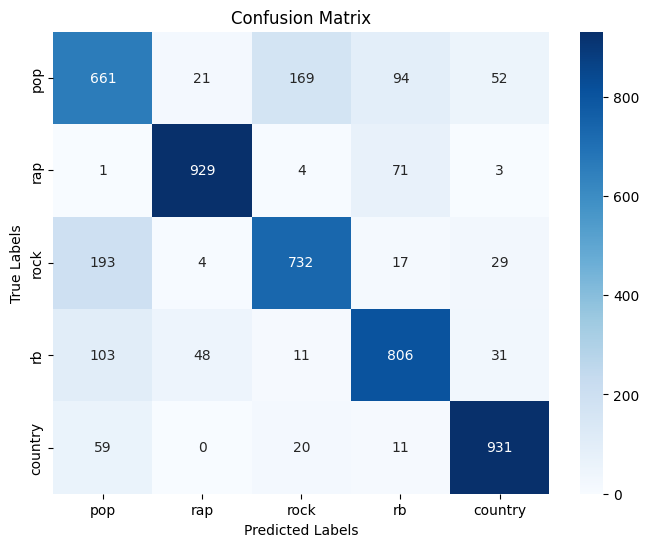

In [62]:
# Calculate the Confusion Matrix
confusion_mat = confusion_matrix(true_labels, predictions, labels=np.unique(true_labels))

# Labels for the axes labels
label_names = list(label_mapping.keys())

# Convert the Confusion Matrix to a Pandas DataFrame
cm_df = pd.DataFrame(confusion_mat, index=label_names, columns=label_names)

# Plot of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [20]:
#torch.save(model, 'llm_model.pth')

In [63]:
#model = torch.load('/kaggle/input/modell/llm_model(1).pth')
#model.to('cuda')

In [65]:
index_to_label = {index: label for label, index in label_mapping.items()}

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

def prepare_text_for_prediction(text, tokenizer, max_length=512):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return encoded_text

def predict_text(text, tokenizer, model, device,index_to_label):
    # Prepare the text for prediction
    inputs = prepare_text_for_prediction(text, tokenizer)

    # Move the inputs to the correct device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict using the model
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        softmax_scores = torch.nn.functional.softmax(logits, dim=1)
        predicted_class_idx = torch.argmax(softmax_scores, dim=1).item()
        predicted_label = index_to_label[predicted_class_idx]
        probabilities = softmax_scores[0].tolist()

    return predicted_label, probabilities

text = "In the heart of the country, under a wide blue sky,Where the fields stretch out like a sweet lullaby.There's a story of love that never grows old,Of a cowboy's heart, brave and bold.Chorus:Whispers on the wind, calling me home,To the place where the wildflowers roam.In your arms, I find my peace,In the country's heart, my soul's release.Verse 2:Under the stars, by the light of the moon,We dance to the tune of an old country tune.With your hand in mine, troubles fade away,In each other's eyes, we find our way.Chorus:Whispers on the wind, calling me home,To the place where the rivers gently roam.In your arms, I find my peace,In the country's heart, love's sweet release.Bridge:Through the storms, through the pain,Our love's like a gentle rain.Washing away all the sorrow,Leading us to a bright tomorrow.Verse 3:As the sun sets, painting the sky,I thank the stars for you and I.In this simple life, we've found our dream,In the country's heart, we're a perfect team.Chorus:Whispers on the wind, calling me home,To the place where the old oaks stand strong.In your arms, I find my peace,In the country's heart, our love's sweet lease.Outro:So here we stand, in love's sweet embrace,In the country's heart, we've found our place.With whispers on the wind, and love so true,In the heart of the country, I found you."
predicted_label, probabilities = predict_text(text, tokenizer, model, device, index_to_label)
print(f"Predicted class: {predicted_label}, Predicted probabilities: {probabilities}")

Predicted class: country, Predicted probabilities: [0.0056227026507258415, 0.0003768062451854348, 0.004092480055987835, 0.0036051934584975243, 0.9863027930259705]


# Evaluation of Final Test Data

In [91]:
df_finaltest = pd.read_csv('/kaggle/input/final-test/final_test_english_songs_10000.csv')

In [93]:
external_lyrics_list = df_finaltest['lyrics'].tolist()
external_tag_list = df_finaltest['tag'].tolist()

external_numeric_labels = torch.tensor([label_mapping[label] for label in external_tag_list])

# Create an external dataset
external_dataset = SongsDataset(external_lyrics_list, external_numeric_labels, tokenizer)

# Create an external data loader
external_dataloader = DataLoader(external_dataset, batch_size=16, shuffle=False)

# Evaluation for the external dataset
model.eval()
total_external_loss = 0
external_predictions = []
external_true_labels = []

for batch in tqdm(external_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    loss = nn.CrossEntropyLoss()(logits, labels)
    total_external_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    external_predictions.extend(np.argmax(logits, axis=1))
    external_true_labels.extend(label_ids)

avg_external_loss = total_external_loss / len(external_dataloader)
print(f"External Dataset Evaluation Loss: {avg_external_loss}")

external_accuracy = accuracy_score(external_true_labels, external_predictions)
external_f1 = f1_score(external_true_labels, external_predictions, average='weighted')

print(f"External Dataset Accuracy: {external_accuracy}")
print(f"External Dataset F1 Score: {external_f1}")

  0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_47/1485424344.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)
  8%|▊         | 52/625 [00:13<02:24,  3.97it/s]


KeyboardInterrupt: 

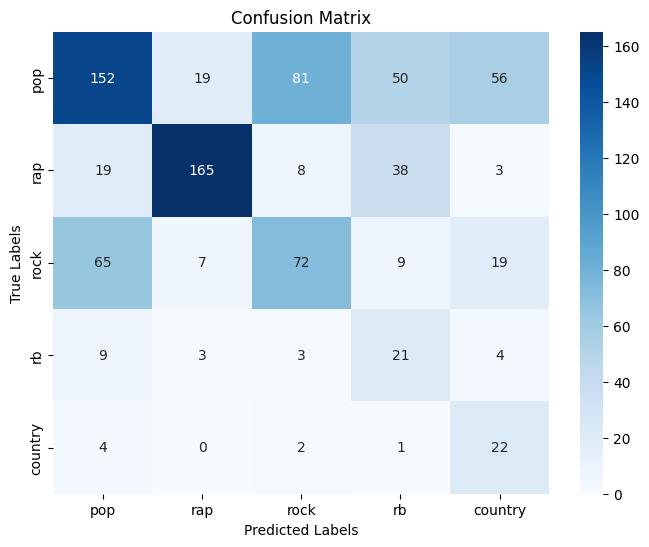

In [94]:
# Calculate the Confusion Matrix
confusion_mat = confusion_matrix(external_true_labels, external_predictions, labels=np.unique(external_true_labels))

# Labels for the axes labels
label_names = list(label_mapping.keys())

# Convert the Confusion Matrix to a Pandas DataFrame
cm_df = pd.DataFrame(confusion_mat, index=label_names, columns=label_names)

# Plot of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [95]:
from sklearn.metrics import classification_report

# Classification Report for the external dataset
print("Classification Report for External Dataset")

model.eval()
total_external_loss = 0
external_predictions = []
external_true_labels = []

for batch in tqdm(external_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    loss = nn.CrossEntropyLoss()(logits, labels)
    total_external_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    external_predictions.extend(np.argmax(logits, axis=1))
    external_true_labels.extend(label_ids)

avg_external_loss = total_external_loss / len(external_dataloader)
print(f"External Dataset Evaluation Loss: {avg_external_loss}")

external_accuracy = accuracy_score(external_true_labels, external_predictions)
print(f"External Dataset Accuracy: {external_accuracy}")

# Create the Classification Report for the external dataset
external_report = classification_report(external_true_labels, external_predictions, target_names=label_mapping.keys())
print("Classification Report for External Dataset:")
print(external_report)


Classification Report for External Dataset


  0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_47/1485424344.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)
  2%|▏         | 13/625 [00:03<02:47,  3.65it/s]


KeyboardInterrupt: 